In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from BabelViscoFDTD.H5pySimple import ReadFromH5py,SaveToH5py
from BabelViscoFDTD.PropagationModel import PropagationModel
from BabelViscoFDTD.tools.RayleighAndBHTE import *
PModel=PropagationModel()

StaggeredFDTD_3D_CPU loaded
StaggeredFDTD_3D_CUDA NOT loaded
StaggeredFDTD_3D_OPENCL loaded
StaggeredFDTD_3D_METAL loaded
loading /opt/homebrew/Caskroom/miniforge/base/envs/p39/lib/python3.9/site-packages/BabelViscoFDTD/tools/libBabelMetal.dylib
loaded Metal <CDLL '/opt/homebrew/Caskroom/miniforge/base/envs/p39/lib/python3.9/site-packages/BabelViscoFDTD/tools/libBabelMetal.dylib', handle 201efd000 at 0x1369ea520>


# Simple case of Water only simulation - plane circular transducer
In this simple example we will cover the basics of the FDTDStaggered3D operation, which involves:
* Defining a domain size
* Specifying an acoustic source
* Specifying regions of domain as sensors
* Execute simulation and show results

## Defintions of medium-domain
First step is to define a domain, in this example we will execute a simulation of a piston source (diam of 3 cm) operating at 350 kHz in a water-only domain of 5$\times$5$\times$10 cm. You can see below how the perfect matching layer (PML) needs to be accounted.

In [11]:
Frequency = 350e3  # Hz
MediumSOS = 1500 # m/s - water
MediumDensity=1000 # kg/m3

ShortestWavelength =MediumSOS / Frequency
SpatialStep =ShortestWavelength / 9 # A minimal step of 6 is recommnded

DimDomain =  np.array([0.05,0.05,0.10])  # in m, x,y,z

Amplitude= 100e3 #Pa
AmplitudeDisplacement=Amplitude/MediumDensity/MediumSOS # We use a 100 kPa source, we just need to convert to particle displacement

TxDiam = 0.03 # m, circular piston
TxPlaneLocation = 0.01  # m , in XY plane at Z = 0.01 m

PMLThickness = 12 # grid points for perect matching layer, 
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, 

N1=int(np.ceil(DimDomain[0]/SpatialStep)+2*PMLThickness)
N2=int(np.ceil(DimDomain[1]/SpatialStep)+2*PMLThickness)
N3=int(np.ceil(DimDomain[2]/SpatialStep)+2*PMLThickness)
print('Domain size',N1,N2,N3)
TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/MediumSOS #time to cross one corner to another
TemporalStep=1.5e-7 
StepsForSensor=int((1/Frequency/8)/TemporalStep) # for the sensors, we do not need so much high temporal resolution, so we are keeping 8 time points per perioid

COMPUTING_BACKEND=2 # 0 for CPU, 1 for CUDA, 2 for OpenCL, 3 for Metal
DefaultGPUDeviceName='M1' # ID of GPU

Domain size 129 129 234


## Material map definition
The material map is a finite distribution of the type of materials present in the simulation domain. In this example, a simple homogenous map is present.

A material list is an array of N$\times$5 where N is the number of different materials.
* The first column (0) is **density** (kg/m$^3$)
* The second column (1) is **Longitudinal speed of sound** (m/s)
* The third column (2) is **Shear speed of sound** (m/s)
* The fourth column (3) is **Longitudinal attenuation** (Np/m)
* The fifth column (4) is **Shear attenuation** (Np/m)

In [12]:
MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((1,5)) # one material in this examples
MaterialList[0,0]=MediumDensity # water density
MaterialList[0,1]=MediumSOS # water SoS
#all other parameters are set to 0 


## Source definition  - particle displacement
The **source map** is a N1 $\times$ N2 $\times$ N3 integer array where anything different from 0 is considered a source of particle displacement ($V_x$, $V_y$, $V_z$). A **Pulse source** array with M$\times$number-of-time-points is associated to the source map. For example, entries in the source map with a value of 1 mean that those entries will use the source function in pulse source at location [0,:]; entries in the source map with a value of 4 mean they will use the  source function in pulse source at location [3,:]. Note the index in the pulse source is -1 compared to the source map (1->0, 2->1, and so on).

Besides defining the location of the sources, the **orientation** of the particle displacement must be provided. This is very important as this provides the directivty of the mechanical wave. In this example, as the source is defined in a $XY$ plane, we choose a [0,0,1] vector to indicate the wave is primarily propagating in the $Z$ direction.

## Source definition  - stress
The source can also be defined for stress. The **source map** is a N1 $\times$ N2 $\times$ N3 integer array where anything different from 0 is considered a source of stress ($\sigma_x$, $\sigma_y$, $\sigma_z$). Similar conditions apply for the **Pulse source** array as for the case of particle displacement. When using an stress source, the three stressess are asigned the same value over time. No orientation vector is applied when using an stress source.

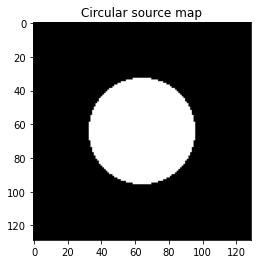

In [13]:
def MakeCircularSource(DimX,DimY,SpatialStep,Diameter):
    #simple defintion of a circular source centred in the domain
    XDim=np.arange(DimX)*SpatialStep
    YDim=np.arange(DimY)*SpatialStep
    XDim-=XDim.mean()
    YDim-=YDim.mean()
    XX,YY=np.meshgrid(XDim,YDim)
    MaskSource=(XX**2+YY**2)<=(Diameter/2.0)**2
    return (MaskSource*1.0).astype(np.uint32)

SourceMask=MakeCircularSource(N1,N2,SpatialStep,TxDiam)
plt.imshow(SourceMask,cmap=plt.cm.gray);
plt.title('Circular source map')

SourceMap=np.zeros((N1,N2,N3),np.uint32)
LocZ=int(np.round(TxPlaneLocation/SpatialStep))+PMLThickness
SourceMap[:,:,LocZ]=SourceMask 

Ox=np.zeros((N1,N2,N3))
Oy=np.zeros((N1,N2,N3))
Oz=np.zeros((N1,N2,N3))
Oz[SourceMap>0]=1 #only Z has a value of 1

78


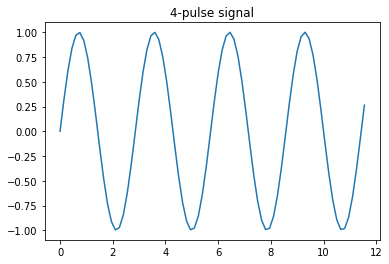

In [14]:
LengthSource=4.0/Frequency #we will use 4 pulses
TimeVectorSource=np.arange(0,LengthSource+TemporalStep,TemporalStep)

PulseSource = np.sin(2*np.pi*Frequency*TimeVectorSource)
plt.figure()
plt.plot(TimeVectorSource*1e6,PulseSource)
plt.title('4-pulse signal')

#note we need expressively to arrange the data in a 2D array
PulseSource=np.reshape(PulseSource,(1,len(TimeVectorSource))) 
print(len(TimeVectorSource))

## Sensor map definition
The **sensor map** is a N1$\times$N2$\times$N3 integer array where anything different from 0 is considered a sensor. Sensor map will specify locations where temporal data will be collected.
In this example, we will collect data in the central plane.

Text(0.5, 1.0, 'Sensor map location')

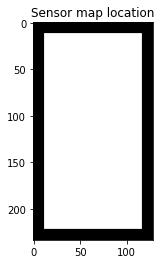

In [15]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

plt.figure()
plt.imshow(SensorMap[:,int(N2/2),:].T,cmap=plt.cm.gray)
plt.title('Sensor map location')

## Verify conditions of simulation - optional
The simulation is executed with the function `StaggeredFDTD_3D_with_relaxation`. However, if passing the parameter `CheckOnlyParams=True` a quick verifcation of the simulation conditions is executed, especially regarding the temporal step that can be used to verify that stability conditions are met. Also, this option helps to identify potential mistakes in much more complex domains (such as transmission through bone material) in the definition of density, speeds of sound, etc. The viscoelastic simulation will transform the definition of the acoustic domain into elastic conditions as Lamé parameters ($\mu$, $\lambda$). For example, the Poison ratio of every voxel must be between -1.0 and 0.5. Any value ourside that range would suggest that a mistake in the material definition took place. Attenuation coefficients are transformed to $Q$-factor coefficients that use memory-type matrices to model attenuation losses. Consult the `PropagationModel.py` file for details.

In [16]:

StabilityConditions,largestDT=PModel.StaggeredFDTD_3D_with_relaxation(MaterialMap,
                                             MaterialList,
                                             Frequency,
                                             SourceMap,
                                             PulseSource,
                                             SpatialStep,
                                             TimeSimulation,
                                             SensorMap,
                                             Ox=Ox*AmplitudeDisplacement,
                                             Oy=Oy*AmplitudeDisplacement,
                                             Oz=Oz*AmplitudeDisplacement,
                                             NDelta=PMLThickness,
                                             ReflectionLimit=ReflectionLimit,
                                             COMPUTING_BACKEND=COMPUTING_BACKEND,
                                             USE_SINGLE=True,
                                             DT=TemporalStep,
                                             QfactorCorrection=True,
                                             DefaultGPUDeviceName=DefaultGPUDeviceName,
                                             TypeSource=1,
                                             CheckOnlyParams=True)
#If returns True, it means stability conditions are met, the largest value of temporal step is printed for reference

print('Conditions of stability =',StabilityConditions,', largest dt',largestDT)


Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
Conditions of stability = True , largest dt 1.5553109292455225e-07


## Execute simulation
To execute the simulation, call the same function without `CheckOnlyParams` (or set to `FALSE`). Besides the parameters specifying the domain, source and sensors, a few extra parameters are specified, **including what CPU/GPU backend to utilize**:
* `MaterialMap`: 3D distribution of different types of material (described above, N1$\times$N2$\times$N3)
* `MaterialList`: Properties of materials (described above) (M$\times$ 5, M is maximal type of material, double)
* `Frequency`: (Hz, double)
* `SourceMap`: 3D distribution of source location (described above)
* `PulseSource`: Time-domain functions of sources (described above)
* `SpatialStep`: Spatial step of domain (in meters, only isotropic conditions are supported, double)
* `TimeSimulation`: Duration of simulation (s, double)
* `SensorMap`: 3D distribution of location of sensors (described above)
* `IntervalSnapshots`: If -1, no snapshots are taken default to -1
* `NDelta`: Size of PML (default of 12)
* `Ox`, `Oy` and `Oz`: Optional 3D distribution of the particle displacement vector (described above, default to [1])
* `ReflectionLimit`: PML reflection parameter (default of 1e-5)
* `COMPUTING_BACKEND`: 0= use CPU (OpenMP in all available cores in Linux and Windows), 1 = Use CUDA, 2 = Use OpenCL, 3 = Metal
* `USE_SINGLE` : boolean, if True,  simulations will be run with float32 precision (all casts are done inside function). If False, simulations will be run in float64 precision
* `DT`: Temporal step (in seconds)
* `QfactorCorrection`: boolean, modification to Lamé values when attenuation is specified (highly recommended to set True, default of True if not specified)
* `DefaultGPUDeviceName`: String of GPU id (for example "Radeon", "GTX 2080", etc.) to be chosen if GPU backend is used. This is useful in multi-GPU system and it is desired to select the GPU to run the simulations for optimal performance. If unsure of this ID, do a quick run with a dummy string as ID  as the function will print out all the available GPUs in the system, then you can modify the call to indicate the ID of the chosen GPU.
* `TypeSource`: 0 for soft source displacement (the FDTD will "add" the source function during the solution), 1 for hard source displacement (the FDTD will enforce the source function (Dirlecht condition)), 2 for soft source stress, 3 for hard source stress
* `SelRMSorPeak`: select collecting RMS (1), Peak (2) or both (3). Default is only RMS (1)
* `SelMapsRMSPeakList`: This is a list of the desired maps to be collected for RMS/Peak. By default it collects ['ALLV'], which is the amplitude of the vector particle displacement . You can specify one or more of ['ALLV','Vx','Vy','Vz','Pressure','Sigmaxx','Sigmayy', 'Sigmazz','Sigmaxy','Sigmaxz','Sigmayz']. 
* `SelMapsSensorsList`: This is a list of the desired maps to be collected in sensor regions. By default it collects ['Vx','Vy','Vz']. . You can specify one or more of ['ALLV','Vx','Vy','Vz','Pressure','Sigmaxx','Sigmayy', 'Sigmazz','Sigmaxy','Sigmaxz','Sigmayz']
* `SensorSubSampling`: uint, this indicates the subsampling to be used for the sensor data. The temporal step is often much higher than Nyquist (~20 points per period), so this allows to reduce memory to track sensor data. Default is 2.
* `SensorStart`: uint, this indicates the time point (in terms of 'SensorSubSampling') when the sensor, peak and RMS will start to be collected. For example, assuming the time duration lasts 1000 temporal steps, if 'SensorSubSampling'==1 and 'SensorStart' == 900, then the last 100 sensor steps will be used. This is equivalent to 'SensorSubSampling'==2 and 'SensorStart' == 450. This can be very useful for CW-type simulations (and to save memory) where only when steady state conditions are reached. Default is 0.


The function will return four or five objects (depending on `SelRMSorPeak`)

if `SelRMSorPeak` ==1
* `Sensor`: Dictionary of sensor data (same entries as specified in `SelMapsSensorsList`), plus entry 'time' for time vector)
* `LastMap`: Dictionary of last values of viscoelastic matrices ('Vx', 'Vy', 'Vz', 'Sigma_xx', 'Sigma_yy', 'Sigma_zz', 'Sigma_xy', 'Sigma_xz', 'Sigma_yz')
* `DictRMSValue`: Dictionary of 3D distrbution of RMS data collected (same entries as specified in `SelMapsRMSPeakList`
* `InputParam`: Input data (including after transformation to Lamé matrices)

if `SelRMSorPeak` ==2
* `Sensor`: Dictionary of sensor data (same entries as specified in `SelMapsSensorsList`), plus entry 'time' for time vector)
* `LastMap`: Dictionary of last values of viscoelastic matrices ('Vx', 'Vy', 'Vz', 'Sigma_xx', 'Sigma_yy', 'Sigma_zz', 'Sigma_xy', 'Sigma_xz', 'Sigma_yz')
* `DictPeakValue`: Dictionary of 3D distrbution of peak data collected (same entries as specified in `SelMapsRMSPeakList`
* `InputParam`: Input data (including after transformation to Lamé matrices)

if `SelRMSorPeak` ==3
* `Sensor`: Dictionary of sensor data (same entries as specified in `SelMapsSensorsList`), plus entry 'time' for time vector)
* `LastMap`: Dictionary of last values of viscoelastic matrices ('Vx', 'Vy', 'Vz', 'Sigma_xx', 'Sigma_yy', 'Sigma_zz', 'Sigma_xy', 'Sigma_xz', 'Sigma_yz')
* `DictRMSValue`: Dictionary of 3D distrbution of RMS data collected (same entries as specified in `SelMapsRMSPeakList`
* `DictPeakValue`: Dictionary of 3D distrbution of peak data collected (same entries as specified in `SelMapsRMSPeakList`
* `InputParam`: Input data (including after transformation to Lamé matrices)


Please note that 'Pressure' is calculated as a sub-product using $V_x$, $V_y$ and $V_z$ derivatives and the mass conservation law ($\frac{\partial(p)}{\partial(t)} = \rho c^2 \nabla \cdot V$)

### Extra optional parameters
* `SILENT`: If True, reduces verbosity of output. Default is False
* `DefaultGPUDeviceNumber`: Number of GPU associated to `DefaultGPUDeviceName` in multi-GPU systems with same type of device. This helps to select an specific GPU in an installation that has multiple identical devices. This only applies for CUDA-based systems. Default is 0
* `ManualGroupSize`: An array of size 3 (np.int32) specifying the grid block size to be used by the computing backend. 
* `ManualLocalSize`: An array of size 3 (np.int32) specifying the block thread size to be used by the computing backend. BabelViscoFDTD uses the methods to calculate `ManualGroupSize` and `ManualLocalSize` that are recommended for each backend for maximal GPU occupancy. In most cases, the internal calculations of these parameters will provide the best possible performance. However, in certain domain size conditions, manual adjustments can indeed improve the performance. Please consult guidelines of each backend (CUDA, OpenCL and Metal) on how to calculate this correctly, otherwise there is a risk of specifying a too large or too short grid and thread size dimensions. For example, for both CUDA and Metal, the multiplication of `ManualGroupSize` and `ManualLocalSize` must be equal or larger than [N1,N2,N3] to ensure all the domain is covered; for example for a domain of size [231,220,450], `ManualGroupSize=[60,60,115]` with `ManualLocalSize=[4,4,4]` will ensure covering the domain size. For `OpenCL` each entry in `ManualGroupSize` must be equal or larger than [N1,N2,N3] and each entry must be a multiple of its corresponding entry in `ManualLocalSize`; for example for a domain of size [231,220,450], `ManualGroupSize=[240,240,460]` with `ManualLocalSize=[4,4,4]`. Be sure of specifying these parameters as an np.array of type np.int32, such as `ManualLocalSize=np.array([4,4,4]).astype(np.int32)`. 


In [17]:
# StartMetaCapture('M1')

Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         Ox=Ox*AmplitudeDisplacement,
                                                         Oy=Oy*AmplitudeDisplacement,
                                                         Oz=Oz*AmplitudeDisplacement,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=COMPUTING_BACKEND,
                                                         USE_SINGLE=True,
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         SelRMSorPeak=1, #we select  only RMS data
                                                         SelMapsRMSPeakList=['Pressure'],
                                                         SelMapsSensorsList=['Vx','Vy','Vz','Pressure'],
                                                         SensorSubSampling=StepsForSensor,
                                                         DefaultGPUDeviceName=DefaultGPUDeviceName,
                                                         TypeSource=0)
# Stopcapture()

Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1.5e-07 1.5553109292455225e-07
Matrix size= 129 x 129 x 234 , spatial resolution = 0.00047619, time steps = 545, temporal step = 1.5e-07, total sonication length 8.16497e-05 
Performing Simulation with GPU OPENCL
Device  M1  Found!
Address bits 64
Number Selected Sensor Maps: 1
Allocating for LambdaMiuMatOverH 1 elements
Allocating for LambdaMatOverH 1 elements
Allocating for MiuMatOverH 1 elements
Allocating for TauLong 1 elements
Allocating for OneOverTauSigma 1 elements
Allocating for TauShear 1 elements
Allocating for InvRhoMatH 1 elements
Allocating for Ox 3893994 elements
Allocating for Oy 3893994 elements
Allocating for Oz 3893994 elements
Allocating for SourceFu

KeyError: 'Snapshots'

### Ploting data
We first plot a couple of slices of the RMSMaps, where we can see the characterist acoustic field of a circular flat source

In [ ]:
RMSValue=DictRMSValue['Pressure'].copy()/1e6 # in MPa
RMSValue[:,:,LocZ-2:LocZ+2]=0 # we hide the values too close to the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValue[:,int(N2/2),:].T)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValue[:,:,int(N3/2)].T)
plt.colorbar()

We calculate now peak and RMS values from the sensor data in the plane for $V$ components

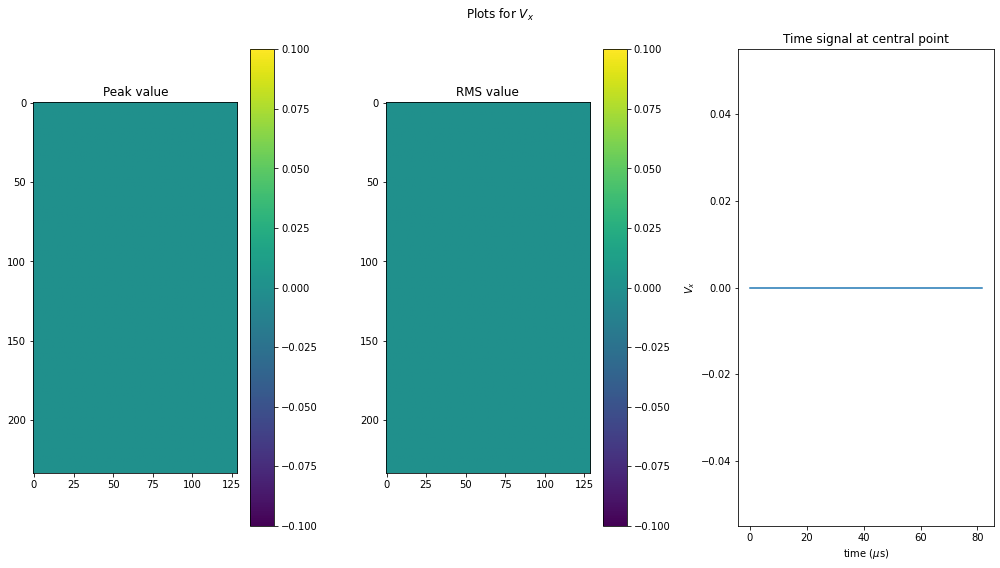

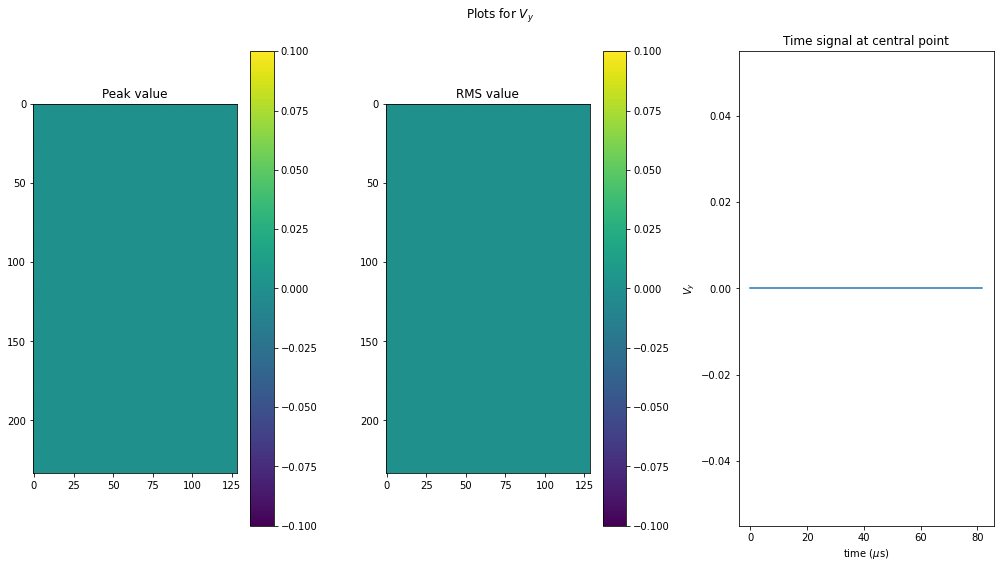

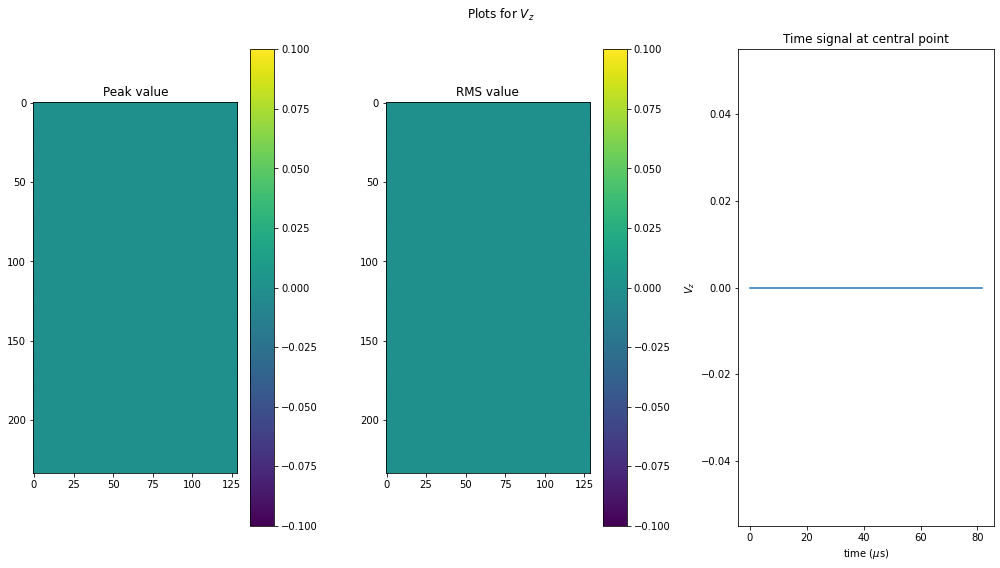

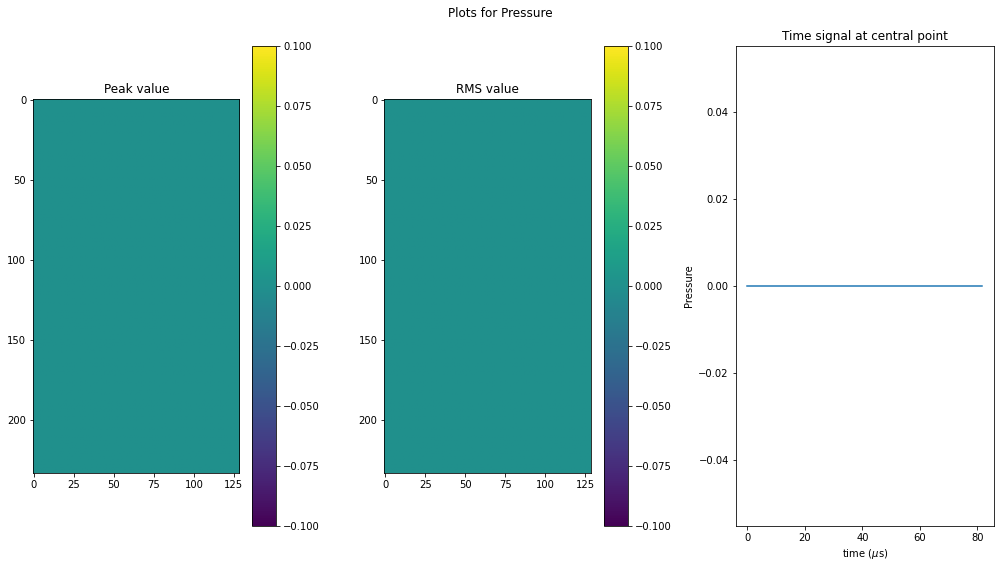

In [10]:
#To remain compatible with Matlab (which uses a Fortran convention for arrays, the index need to be rebuilt)
MaxSensorPlane=np.zeros((N1,N3))
RMSSensorPlane=np.zeros((N1,N3))

for s in ['Vx','Vy','Vz','Pressure']:
    #We use the IndexSensorMap array that was used in the low level function to 
    for n, index in enumerate( InputParam['IndexSensorMap']): 
        k=int(index/(N1*N2))
        j=int(index%(N1*N2))
        i=int(j%N1)
        j=int(j/N1)
        assert(j==int(N2/2)) #all way up we specified the XZ plane at N2/2, this assert should pass
        if i==int(N1/2) and k==int(N3/2):
            CentralPoint=n #we save this to later plot the time signal at the center
        MaxSensorPlane[i,k]=np.max(Sensor[s][n,:])
        RMSSensorPlane[i,k]=np.sqrt(1./len(Sensor[s][n,:])*np.sum(Sensor[s][n,:]**2))
    MaxSensorPlane[:,LocZ-2:LocZ+2]=0
    RMSSensorPlane[:,LocZ-2:LocZ+2]=0
    
    plt.figure(figsize=(14,8))
    plt.subplot(1,3,1)
    plt.imshow(MaxSensorPlane.T)
    plt.title('Peak value')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(RMSSensorPlane.T)
    plt.title('RMS value')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.plot(Sensor['time']*1e6,Sensor[s][CentralPoint])
    plt.xlabel('time ($\mu$s)')
    if s[0]=='V':
        plt.ylabel('$'+s[0]+'_'+s[1]+'$')
    else:
        plt.ylabel(s)
    plt.title('Time signal at central point')
    if s[0]=='V':
        plt.suptitle('Plots for $'+s[0]+'_'+s[1]+'$')
    else:
        plt.suptitle('Plots for ' +s)
    plt.tight_layout()


We can clearly see that the field is mostly defined a displacement map on the $V_z$ direction.

# Peak data 
We select now collecting only peak data instead of RMS

In [14]:
Sensor,LastMap,DictPeakValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         Ox=Ox*AmplitudeDisplacement,
                                                         Oy=Oy*AmplitudeDisplacement,
                                                         Oz=Oz*AmplitudeDisplacement,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=COMPUTING_BACKEND,
                                                         USE_SINGLE=True,
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         SelRMSorPeak=2, #we select now only peak data
                                                         SelMapsRMSPeakList=['Pressure'],
                                                         SelMapsSensorsList=['Vx','Vy','Vz'],
                                                         SensorSubSampling=StepsForSensor,
                                                         DefaultGPUDeviceName=DefaultGPUDeviceName,
                                                         TypeSource=0)

Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1.5e-07 1.5553109292455225e-07
Matrix size= 129 x 129 x 234 , spatial resolution = 0.00047619, time steps = 545, temporal step = 1.5e-07, total sonication length 8.16497e-05 
Performing Simulation with GPU METAL
Attempting Metal Initiation...
Selecting device:  Apple M1 Max
metalcompute.Device(Apple M1 Max)
Number Selected Sensor Maps: 1
Allocating for V_x_x 1608931 elements
Allocating for V_y_x 1608931 elements
Allocating for V_z_x 1608931 elements
Allocating for V_x_y 1608931 elements
Allocating for V_y_y 1608931 elements
Allocating for V_z_y 1608931 elements
Allocating for V_x_z 1595386 elements
Allocating for V_y_z 1595386 elements
Allocating for V_z_z 1595386 eleme

### Ploting data

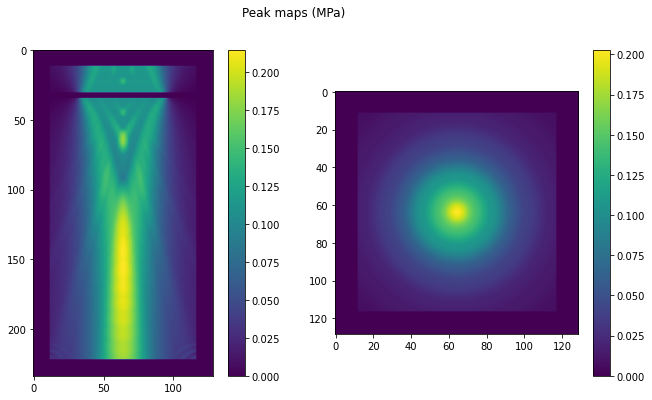

In [15]:
PeakValue=DictPeakValue['Pressure'] 
PeakValue[:,:,LocZ-2:LocZ+2]=0 # we hide the values too close to the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(PeakValue[:,int(N2/2),:].T/1e6)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(PeakValue[:,:,125].T/1e6)
plt.colorbar()
plt.suptitle('Peak maps (MPa)');

We can see the profile looks a bit different compared to the RMS, and the plot matches to what was shown above if calculated from the sensor data. This is expected as the **choice** of what to collect depends on what you intend to study. 

For the sake of demonstration, we will one one more now collecting both peak and RMS maps

In [16]:
Sensor,LastMap,DictRMSValue,DictPeakValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         Ox=Ox*AmplitudeDisplacement,
                                                         Oy=Oy*AmplitudeDisplacement,
                                                         Oz=Oz*AmplitudeDisplacement,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=COMPUTING_BACKEND,
                                                         USE_SINGLE=True,
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         SelRMSorPeak=3, #we select now both RMS and peak data
                                                         SelMapsRMSPeakList=['Pressure'],
                                                         SelMapsSensorsList=['Vx','Vy','Vz'],
                                                         SensorSubSampling=StepsForSensor,
                                                         DefaultGPUDeviceName=DefaultGPUDeviceName,
                                                         TypeSource=0)

Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1.5e-07 1.5553109292455225e-07
Matrix size= 129 x 129 x 234 , spatial resolution = 0.00047619, time steps = 545, temporal step = 1.5e-07, total sonication length 8.16497e-05 
Performing Simulation with GPU METAL
Attempting Metal Initiation...
Selecting device:  Apple M1 Max
metalcompute.Device(Apple M1 Max)
Number Selected Sensor Maps: 1
Allocating for V_x_x 1608931 elements
Allocating for V_y_x 1608931 elements
Allocating for V_z_x 1608931 elements
Allocating for V_x_y 1608931 elements
Allocating for V_y_y 1608931 elements
Allocating for V_z_y 1608931 elements
Allocating for V_x_z 1595386 elements
Allocating for V_y_z 1595386 elements
Allocating for V_z_z 1595386 eleme

### Ploting data
And we plot them side to side

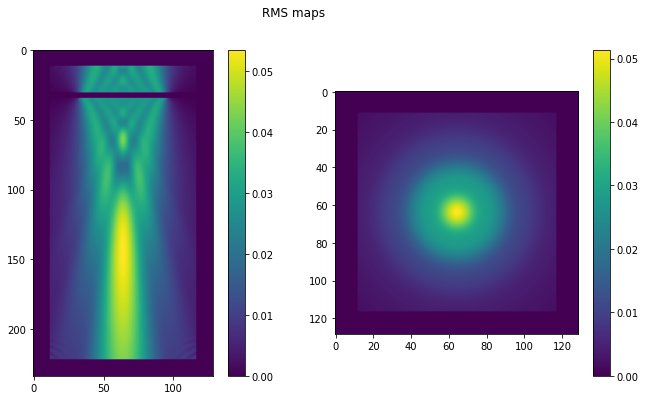

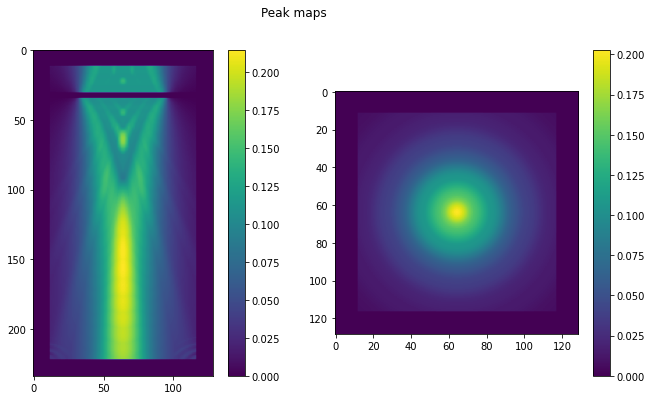

In [17]:
RMSValue=DictRMSValue['Pressure'] 
RMSValue[:,:,LocZ-2:LocZ+2]=0 # we hide the values too close to the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValue[:,int(N2/2),:].T/1e6)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValue[:,:,125].T/1e6)
plt.colorbar()
plt.suptitle('RMS maps');

PeakValue=DictPeakValue['Pressure'] 
PeakValue[:,:,LocZ-2:LocZ+2]=0 # we hide the values too close to the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(PeakValue[:,int(N2/2),:].T/1e6)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(PeakValue[:,:,125].T/1e6)
plt.colorbar()
plt.suptitle('Peak maps');

In [18]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         -PulseSource*Amplitude,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=COMPUTING_BACKEND,
                                                         USE_SINGLE=True,
                                                         DT=TemporalStep,
                                                         QfactorCorrection=True,
                                                         SelRMSorPeak=1, #we select  only RMS data
                                                         SelMapsRMSPeakList=['Pressure'],
                                                         SelMapsSensorsList=['Vx','Vy','Vz','Pressure'],
                                                         SensorSubSampling=StepsForSensor,
                                                         DefaultGPUDeviceName=DefaultGPUDeviceName,
                                                         TypeSource=2) #we use now a stress source

Calculating Relaxation coefficients for  0
 Q unique entries  0
Calculating Relaxation coefficients for  0
 Q unique entries  0
VLongInput,VShearInput [1500.] [0.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 1.5e-07 1.5553109292455225e-07
Matrix size= 129 x 129 x 234 , spatial resolution = 0.00047619, time steps = 545, temporal step = 1.5e-07, total sonication length 8.16497e-05 
Performing Simulation with GPU METAL
Attempting Metal Initiation...
Selecting device:  Apple M1 Max
metalcompute.Device(Apple M1 Max)
Number Selected Sensor Maps: 1
Allocating for V_x_x 1608931 elements
Allocating for V_y_x 1608931 elements
Allocating for V_z_x 1608931 elements
Allocating for V_x_y 1608931 elements
Allocating for V_y_y 1608931 elements
Allocating for V_z_y 1608931 elements
Allocating for V_x_z 1595386 elements
Allocating for V_y_z 1595386 elements
Allocating for V_z_z 1595386 eleme

### Ploting data
We first plot a couple of slices of the RMSMaps, where we can see the characterist acoustic field of a circular flat source

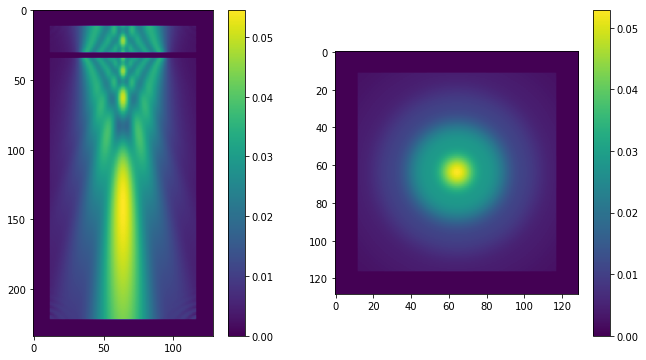

In [19]:
RMSValue=DictRMSValue['Pressure'].copy()/1e6 # in MPa
RMSValue[:,:,LocZ-2:LocZ+2]=0 # we hide the values too close to the source 
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(RMSValue[:,int(N2/2),:].T)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(RMSValue[:,:,125].T)
plt.colorbar()